# DAG Search

We are looking for computational DAG that has lowest loss for given input.

**Example**: 

Symbolic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dag_search

In [2]:
# Symbolic Regression: f(x) = 0.5x, -x
X = np.random.rand(100, 1)
c = 0.5
y = np.column_stack([c*X[:,0], -X[:,0]])

m = X.shape[1]
n = y.shape[1]
k = 1

loss_fkt = dag_search.MSE_loss_fkt(y)

### Exhaustive Search


Pro: 
- you catch every good solution

Con:
- only feasible for shallow computational graphs

100%|████████████████████████████████████████████████████████████████████████████| 864/864 [00:00<00:00, 240119.18it/s]


Total orders: 305
Evaluating orders


100%|████████████████████████████████████████████████████████████████████████████████| 305/305 [00:17<00:00, 17.66it/s]


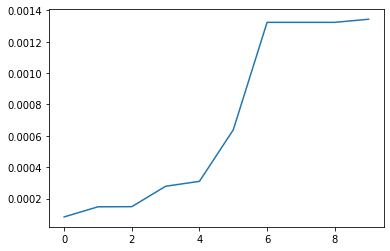

In [12]:
params = {
    'X' : X,
    'n_outps' : n,
    'loss_fkt' : loss_fkt,
    'k' : k,
    'n_calc_nodes' : 1,
    'n_processes' : 1,
    'loss_thresh' : 1e-1,
    'opt_mode' : 'grid',
    'verbose' : 2,
    'max_orders' : 10000, 
    'max_size' : 10
    
}

res = dag_search.exhaustive_search(**params)

plt.plot(res['losses'])

In [13]:
res['graphs'][0].evaluate_symbolic(c = res['consts'][0])

[0.52301810847301*x_0, -x_0]

In [14]:
res['losses'][0]

8.314318099021446e-05

### Sampling

Pro: 
- you can go for much deeper graphs faster

Con:
- youre almost guaranteed to miss something

Generating graphs


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1208.36it/s]


Evaluating graphs


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 665.81it/s]


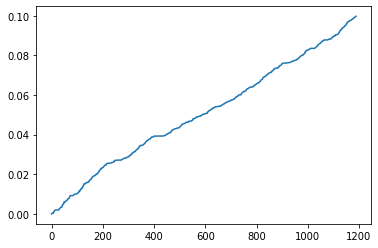

In [15]:
np.random.seed(0)
params = {
    'X' : X,
    'n_outps' : n,
    'loss_fkt' : loss_fkt,
    'k' : k,
    'n_calc_nodes' : 5,
    'n_processes' : 1,
    'loss_thresh' : 1e-1,
    'opt_mode' : 'grid',
    'verbose' : 2,
    'n_samples' : 10000
    
}
res = dag_search.sample_search(**params)

plt.plot(res['losses'])

In [16]:
res['graphs'][0].evaluate_symbolic(c = res['consts'][0])

[0.509535634198189*x_0, -x_0]

In [17]:
res['losses'][0]

1.4268769966419193e-05